In [8]:
getwd()

[1] "/hpc/hub_oudenaarden/agiladi/data/tuft"

In [2]:
setwd("..")

In [16]:
library(metacell)
library(Hmisc)
library(RColorBrewer)
source("scripts/metacell_functions.r")
scdb_init("saved_work", force=T)

initializing scdb to saved_work


In [13]:
id = "10x_diff"

dir.create("results")
dir.create("large_text")
outdir = paste0("release_figures/figure4/")
dir.create(outdir)
scfigs_init(outdir)

Warning message in dir.create("results"):
“'results' already exists”Warning message in dir.create("large_text"):
“'large_text' already exists”

In [5]:
source("../tuft/scripts/metacell_functions.r")

#id = "ileum_organoids"
suffix = ""; id_f = paste0(id, suffix)
sc_2d = scdb_mc2d(id); sc_cl = scdb_mc(paste0(id, suffix)); sc_mat = scdb_mat(id)

cells = names(sc_cl@mc)
cell_stats = sc_mat@cell_metadata[cells,]
colnames(cell_stats) = gsub(" ", ".", colnames(cell_stats))
colnames(cell_stats) = gsub("\\(|\\)", "_", colnames(cell_stats))
fp = sc_cl@mc_fp
lfp = log2(sc_cl@mc_fp)


In [6]:
color_scheme = sc_cl@color_key
color2name = as.vector(color_scheme$group); names(color2name) = color_scheme$color
name2color = as.vector(color_scheme$color); names(name2color) = color_scheme$group

#name2color = as.matrix(read.delim("annotations/name2color.txt", h=T, stringsAsFactor=F, row.name=1))[,1]
#color2name = names(name2color); names(color2name) = name2color
sc_names = color2name[ sc_cl@colors[ sc_cl@mc]]; names(sc_names) = names(sc_cl@mc)
annotations = as.matrix(read.delim(paste0("config/lin_ord_", id, ".txt"), stringsAsFactor=F, h=F))[,1]
lin_ord = annotations

pops = names(table(sc_names))

setdiff(pops, lin_ord)
setdiff(lin_ord, pops)

write.table(lin_ord)

character(0)

character(0)

"x"
"1" "Stem_cells"
"2" "Progenitors"
"3" "Immune_resp"
"4" "ITLN1"
"5" "ITLN1_SMOC2"
"6" "Goblet"
"7" "Tuft"
"8" "Enteroendo"
"9" "PLCG2"


In [7]:
lin2name = lin_ord
lin2name[3:5] = c("Immune responsive", "Secretory prog. I", "Secretory prog. II")
names(lin2name) = lin_ord

In [9]:
bad_pops = "PLCG2"
bad_mc = union(which(color2name[ sc_cl@colors] == bad_pops), c())
bad_cells = names(sc_cl@mc)[ sc_cl@mc %in% bad_mc]
good_cells = setdiff(names(sc_cl@mc), bad_cells)
clust_ord = setdiff(order(factor(color2name[ sc_cl@colors], levels = lin_ord)), bad_mc)

message( length(good_cells), " good cells!")

10311 good cells!


In [10]:
head(cell_stats)
comb = paste0(cell_stats$seeder_cell, "@", cell_stats$medium); names(comb) = rownames(cell_stats)
table(comb[ good_cells])

,tag,seeder_cell,medium,umicount,amp_batch_id
AAACCCAAGGATATAC-1,CMO302,non-tuft,diff+IL4/13,5519,1
AAACCCAAGTCTACCA-1,CMO301,non-tuft,diff,8189,1
AAACCCAAGTTGGAAT-1,CMO311,tuft,diff+IL4/13,2714,1
AAACCCACACTCGATA-1,CMO311,tuft,diff+IL4/13,6549,1
AAACCCAGTATATGGA-1,CMO301,non-tuft,diff,3843,1
AAACCCAGTCGGTGAA-1,CMO310,tuft,diff,11183,1



       non-tuft@diff non-tuft@diff+IL4/13            tuft@diff 
                2780                 2528                 2512 
    tuft@diff+IL4/13 
                2491 

png 
  2

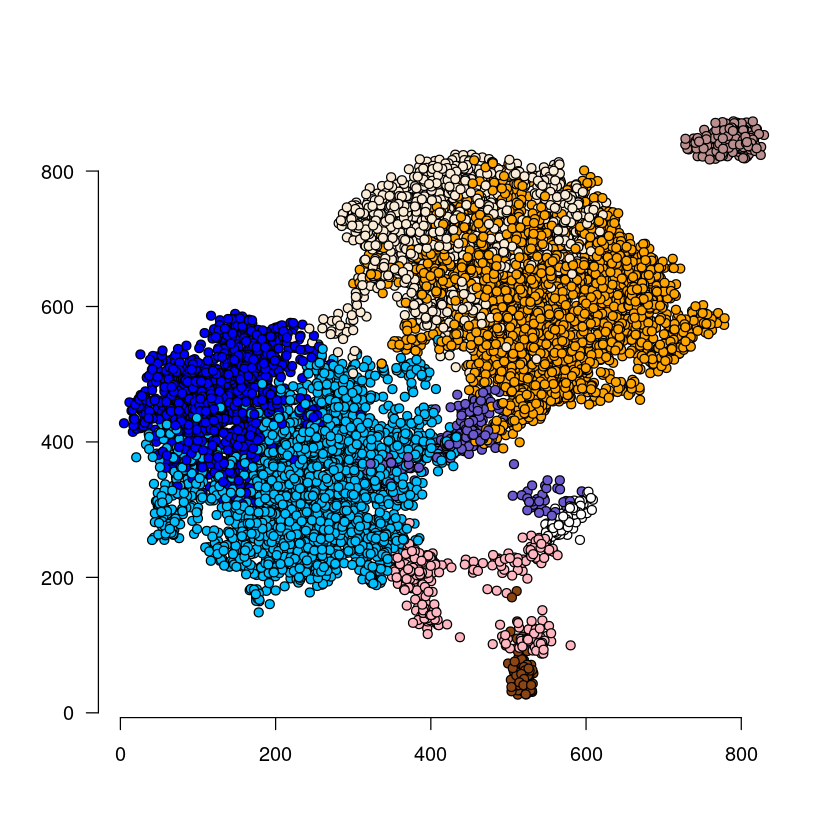

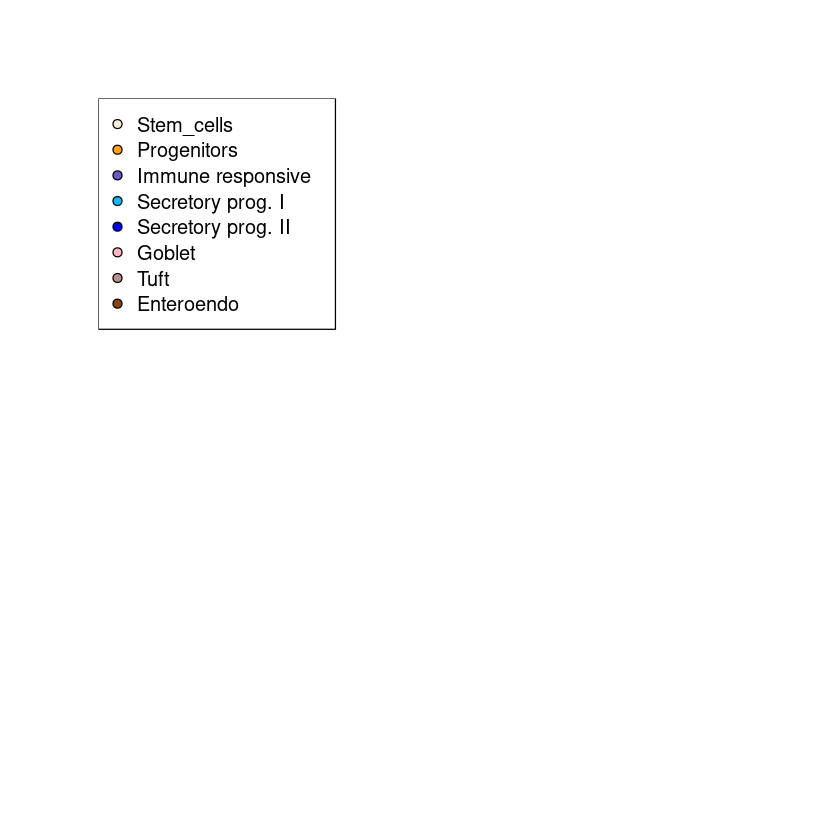

In [14]:
p = function() {
    plot(sc_2d@sc_x[ good_cells], sc_2d@sc_y[ good_cells], pch = 21, bg = sc_cl@colors[ sc_cl@mc[ good_cells]], axes = F,
        xlab = "", ylab = "")
    axis(1); axis(2, las = 2)
    
}

p()
pdf(paste0(outdir, "/Fig4d.pdf"), useDingbats = F)
p()
dev.off()

good_pops = setdiff(lin_ord, bad_pops)
plot.empty()
legend("topleft", lin2name[ good_pops], pch = 21, pt.bg = name2color[ good_pops])


In [15]:

umis = read_large_umis(id, cells = good_cells)
umis_n = sweep(umis, 2, colSums(umis), "/") * 1000


    
    
b=9
genes = c("POU2F3", "KIT", "AVIL",
          "LGR5", "OLFM4", "ITLN1", "FCGBP", "MUC2",
          "CHGA", "NEUROG3", "CHGB")

all_cells = good_cells
p = function(gene) {
    vals = umis_n[gene,]
    pos_vals = vals[ vals > 0]
    quants = unique(quantile(pos_vals, (0:b)/b))
    disp_cells = names(pos_vals)
    val_n = rep(1, length(disp_cells)); names(val_n) = disp_cells
    val_n[ names(pos_vals)] = as.numeric(cut(pos_vals, quants, include.lowest=T)) + 1
    cell_ord = names(sort(val_n))
    grad = c("white", brewer.pal(length(table(val_n)) - 1, "YlGnBu"))
    plot(sc_2d@sc_x[all_cells], sc_2d@sc_y[all_cells], pch = 20, col = "gray",
        axes = F, xlab = "", ylab = "", cex = 1, main = gene)
    points(sc_2d@sc_x[cell_ord], sc_2d@sc_y[cell_ord], pch = 20, cex = 2, col = grad[ val_n[ cell_ord]])
}

invisible(sapply(genes, p))

pdf(paste0(outdir, "/Fig4e_right.pdf"), height=15, width=20, useDingbats=F)
par(mfrow = c(3,4))
invisible(sapply(genes, p))
dev.off()

rfac = 20
df = cbind(x = sc_2d@sc_x[ good_cells], y = sc_2d@sc_y[ good_cells], rx = round(sc_2d@sc_x[ good_cells] / rfac), ry = round(sc_2d@sc_y[ good_cells] / rfac))
dim(df)
df = df[ !duplicated(df[, c("rx", "ry")]),]
dim(df)
head(df)

    library(RColorBrewer)
    
b=9
genes = c("POU2F3", "KIT", "AVIL",
          "LGR5", "OLFM4", "ITLN1", "FCGBP", "MUC2",
          "CHGA", "NEUROG3", "CHGB")
nr = 3
nc = 4
cb = 1 / nc
rb = 1 / nr
locs = cbind(rep(seq_len(nc) - 1, nr), rep(rev(seq_len(nr)) - 1, each = nc))
#all_cells = good_cells
p = function(i) {
    gene = genes[i]
    vals = umis_n[gene,]
    all_cells = names(sort(vals))
    pos_vals = log(1 + 1 * vals[ vals > 0])
    pos_vals = pmin(pos_vals, quantile(pos_vals, 0.99))
    val_n = rep(1, length(good_cells)); names(val_n) = good_cells
    val_n[ names(pos_vals)] = round(100 * pos_vals / max(pos_vals)) + 1
    #grad = colorRampPalette(c("gray", brewer.pal(9, "YlGnBu")))(101)
    grad = colorRampPalette(c("gray90", "gray90", brewer.pal(3, "Reds")))(101)
    cell_ord = names(val_n) #sort(val_n))
    r = locs[i,2]; c = locs[i,1]
    par(fig = c(c / nc, c / nc + cb * 0.85, r / nr, r / nr + rb * 0.85), mar = rep(0.5,4), new = (i > 1))
    plot(df[,"x"], df[,"y"], pch = 20, col = "gray98",
        axes = F, xlab = "", ylab = "", cex = 0.7, main = gene)
    points(sc_2d@sc_x[cell_ord], sc_2d@sc_y[cell_ord], pch = 20, cex = 0.5, col = grad[ val_n[ cell_ord]])
    par (fig = c(c / nc + cb * 0.9, c / nc + cb * 1, r / nr + rb * 0.3, r / nr + rb * 0.6), new=T)
    ax = seq(0, max(pos_vals), length.out = length(grad))
    image(y = ax, t(seq_along(grad)), axes = F, col = grad)
    box(); axis(2, at = quantile(ax, c(0,1)), labels = round(quantile(ax, c(0,1)),2), las = 2)
}

#invisible(sapply(genes, p))

pdf(paste0(outdir, "/feature_maps_2.pdf"), height=15, width=20, useDingbats=F)
#par(mfrow = c(3,4))
invisible(sapply(seq_along(genes), p))
dev.off()

In [18]:
plot_feature_maps = function(i, genes, nr = 2, nc = 3, rfac = 5) {
    cb = 1 / nc
    rb = 1 / nr
    locs = cbind(rep(seq_len(nc) - 1, nr), rep(rev(seq_len(nr)) - 1, each = nc))
    gene = genes[i]
    all_cells = names(sort(umis_n[gene, good_cells]))
    vals = umis_n[gene, good_cells]
    all_cells = names(sort(vals))
    pos_vals = log(1 + 1 * vals[ vals > 0])
    pos_vals = pmin(pos_vals, quantile(pos_vals, 0.99))
    val_n = rep(1, length(all_cells)); names(val_n) = all_cells
    val_n[ names(pos_vals)] = round(100 * pos_vals / max(pos_vals)) + 1
    grad = colorRampPalette(c("gray90", "gray90", brewer.pal(3, "Reds")))(101)
    cell_ord = names(val_n) #sort(val_n))
    r = locs[i,2]; c = locs[i,1]
    par(fig = c(c / nc, c / nc + cb * 0.85, r / nr, r / nr + rb * 0.85), mar = rep(0.5,4), new = (i > 1))
    df = cbind(x = sc_2d@sc_x[ all_cells], y = sc_2d@sc_y[ all_cells], col = grad[ val_n[ all_cells]], 
               rx = round(sc_2d@sc_x[ all_cells] / rfac), ry = round(sc_2d@sc_y[ all_cells] / rfac))
    df = df[ !duplicated(df[, c("col", "rx", "ry")]),]
    dim(df)
    plot(df[,"x"], df[,"y"], pch = 20, cex = 0.7, col = df[,"col"], axes = F, xlab = "", ylab = "", main = gene)
    par (fig = c(c / nc + cb * 0.9, c / nc + cb * 1, r / nr + rb * 0.3, r / nr + rb * 0.6), new=T)
    ax = seq(0, max(pos_vals), length.out = length(grad))
    image(y = ax, t(seq_along(grad)), axes = F, col = grad)
    box(); axis(2, at = quantile(ax, c(0,1)), labels = round(quantile(ax, c(0,1)),3), las = 2)
}


In [21]:
genes = c("POU2F3", "KIT", "AVIL",
          "LGR5", "OLFM4", "ITLN1", "FCGBP", "MUC2",
          "CHGA", "NEUROG3", "CHGB")


pdf(paste0(outdir, "/Fig4e_right.pdf"), height=15, width=20, useDingbats=F)
invisible(sapply(seq_along(genes), plot_feature_maps, genes, 3, 4))
dev.off()

png 
  2

png 
  2

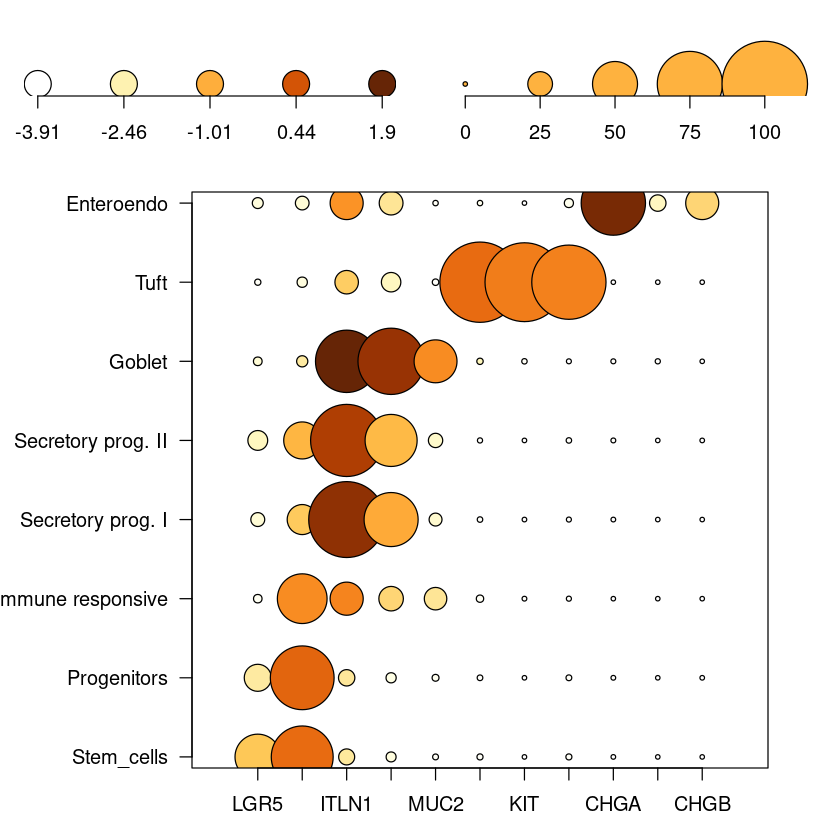

In [22]:
m = t(apply(umis_n[genes, good_cells], 1, tapply, sc_names[ good_cells], mean))
m = m[, intersect(lin_ord, names(which(table(sc_names[ good_cells]) > 20)))]
m = m[ order(max.col(m)),]
IM = log(m + 0.02)
exp_freq = t(apply(umis[rownames(m), good_cells] > 0, 1, tapply, sc_names[ good_cells], mean)) * 100
exp_freq = exp_freq[ ,colnames(m)]

colnames(IM) = lin2name[ colnames(IM)]
dimnames(exp_freq) = dimnames(IM)
grad = colorRampPalette(c("white", brewer.pal(9, "YlOrBr")))(101)

p = function() {
    par(mar = c(3,8,1,3))
    matplot.2(t(IM), t(exp_freq), grad=grad, cex_lim = seq(0,100, by = 25))
}

p()
pdf(paste0(outdir, "/Fig4e_left.pdf"), height=10, width=15, useDingbats = F)
p()
dev.off()

#y = m[,"Tuft"]
#x = apply(m[,setdiff(colnames(m), "Tuft")], 1, max)
pops = c("Stem_cells", "Goblet", "Tuft", "Enteroendo")
y = apply(m[,pops], 1, max)
x = apply(m[,pops], 1, function(x) sort(x,T)[2])
reg = 0.0
lx = log2(reg + x); ly = log2(reg + y)

plot(lx,ly, type = "n"); 
text(lx,ly, names(lx)); 
grid()
abline(coef = c(0,1))

z = y / x
sort(z,T)

genes = c("GAS6", "PROS1",
          "MERTK","TYRO3", "AXL")

m = t(apply(umis_n[genes, good_cells], 1, tapply, sc_names[ good_cells], mean))
m = m[, intersect(lin_ord, names(which(table(sc_names[ good_cells]) > 20)))]
m = m[ order(max.col(m)),]
IM = log(m + 0.02)
exp_freq = t(apply(umis[rownames(m), good_cells] > 0, 1, tapply, sc_names[ good_cells], mean)) * 100
exp_freq = exp_freq[ ,colnames(m)]

colnames(IM) = lin2name[ colnames(IM)]
dimnames(exp_freq) = dimnames(IM)
grad = colorRampPalette(c("white", brewer.pal(9, "YlOrBr")))(101)

p = function() {
    par(mar = c(3,8,1,3))
    matplot.2(t(IM), t(exp_freq), grad=grad, cex_lim = seq(0,100, by = 25))
}

p()
pdf(paste0(outdir, "/gas6_and_receptors.pdf"), height=10, width=15, useDingbats = F)
p()
dev.off()

In [23]:
head(cell_stats)

comb = with(cell_stats, paste0(medium, "@", seeder_cell)); names(comb) = rownames(cell_stats)
table(comb)

comb_cols = c("#D3DEE0", "antiquewhite", "dodgerblue", "darkorange2"); names(comb_cols) = names(table(comb))

,tag,seeder_cell,medium,umicount,amp_batch_id
AAACCCAAGGATATAC-1,CMO302,non-tuft,diff+IL4/13,5519,1
AAACCCAAGTCTACCA-1,CMO301,non-tuft,diff,8189,1
AAACCCAAGTTGGAAT-1,CMO311,tuft,diff+IL4/13,2714,1
AAACCCACACTCGATA-1,CMO311,tuft,diff+IL4/13,6549,1
AAACCCAGTATATGGA-1,CMO301,non-tuft,diff,3843,1
AAACCCAGTCGGTGAA-1,CMO310,tuft,diff,11183,1


comb
       diff@non-tuft            diff@tuft diff+IL4/13@non-tuft 
                3082                 2682                 2870 
    diff+IL4/13@tuft 
                2897 

In [24]:
cols = c("darkorange2", "antiquewhite", "gray", "#D3DEE0", "#897155", "#7030A0")
names(cols) = c("stimulated", "naive", "KO", "epithel", "fetal", "traced")
cols

stimulated          naive             KO        epithel          fetal 
 "darkorange2" "antiquewhite"         "gray"      "#D3DEE0"      "#897155" 
        traced 
     "#7030A0"

png 
  2

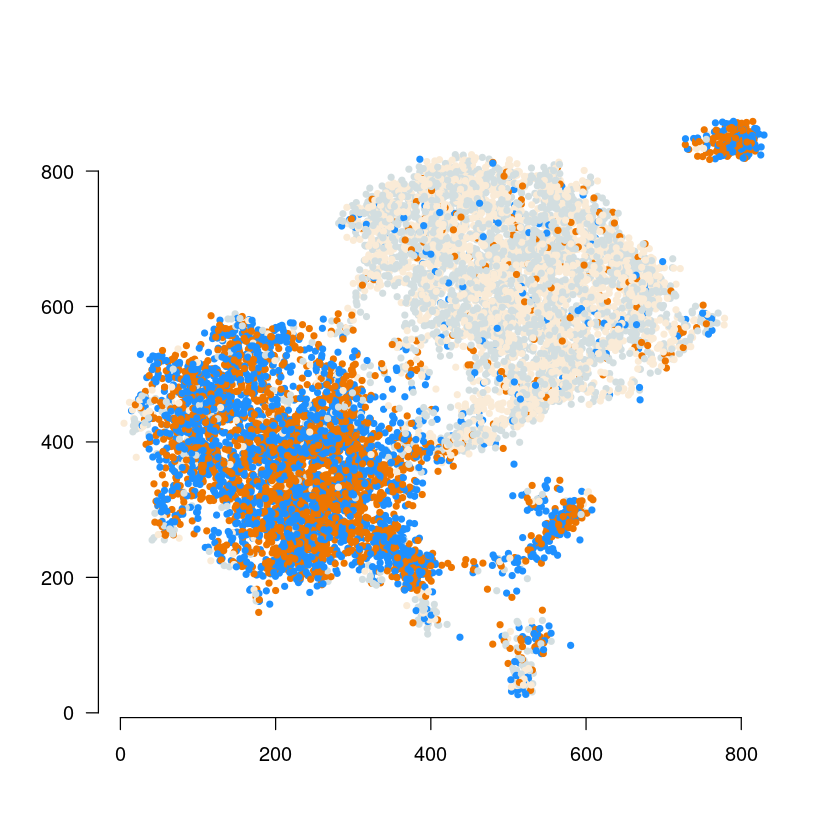

In [26]:
p = function() {
    plot(sc_2d@sc_x[ good_cells], sc_2d@sc_y[ good_cells], pch = 20, col = comb_cols[ comb[ good_cells]], axes = F,
        xlab = "", ylab = "")
    axis(1); axis(2, las = 2)

}

p()
pdf(paste0(outdir, "/Fig4f.pdf"), useDingbats = F)
p()
dev.off()


png 
  2

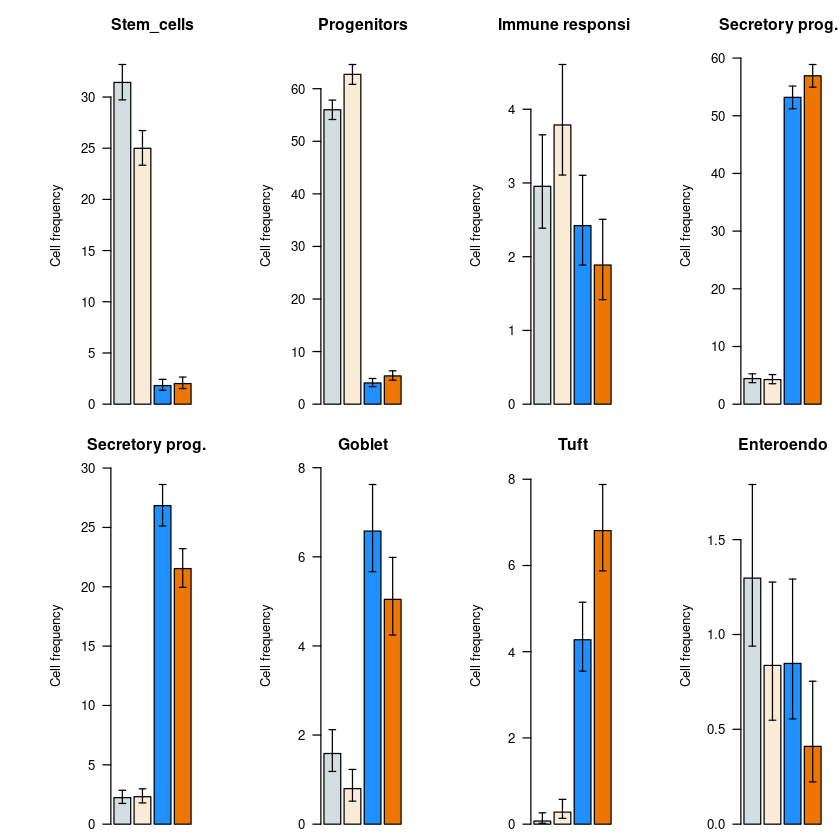

In [30]:
sample_dist = table(comb[ good_cells], factor(sc_names[ good_cells], levels = setdiff(lin_ord, bad_pops)))

p = function() {
    par(mfrow = c(2,4), mar = c(1, 5, 3, 1))
    for(c in good_pops) {
        bconf = 100 * binconf(sample_dist[,c], rowSums(sample_dist)); rownames(bconf) = rownames(sample_dist) 
        par(mar = c(1,7,3,1))
        coords = barplot(bconf[,"PointEst"], las = 2, main = lin2name[c], ylab = "Cell frequency", ylim = c(0, 1.05 * max(bconf[,"Upper"])), names.arg = rep("", nrow(sample_dist)),
                        col = comb_cols[ rownames(sample_dist)])
        segments(coords, bconf[,"Lower"], y1 = bconf[,"Upper"])
        segments(coords - 0.2, bconf[,"Lower"], coords + 0.2)
        segments(coords - 0.2, bconf[,"Upper"], coords + 0.2)
    }
}

p()
pdf(paste0(outdir, "/Fig4g.pdf"), height = 6, width=12)
p()
dev.off()